# 01 - Importing


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/nlp_exam

/content/drive/MyDrive/nlp_exam


In [3]:
!pip install --quiet transformers
#!pip install --q imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.0 MB/s eta 0:00:00


In [4]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import re
import string
import unicodedata

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Machine Learning and Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
import spacy
from spacy.util import compounding, minibatch
import keras
from keras.models import Sequential, load_model, Model
from keras.initializers import Constant
from keras.layers import (LSTM, Embedding, BatchNormalization, Dense, Input,
                          TimeDistributed, Dropout, Bidirectional, Flatten,
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

# Model Evaluation and Metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             classification_report, accuracy_score,
                             confusion_matrix)

# Tokenization and Transformers
from tqdm import tqdm
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification

# Miscellaneous
import random
import os
from collections import Counter, defaultdict
from tabulate import tabulate

# Downloading NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 02 - Preprocessing of the dataset

In [5]:
df = pd.read_csv("spam.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

In [6]:
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df['target_encoded'] = df['target'].map({'spam':1, 'ham':0})
df.head()

,target,message,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [8]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

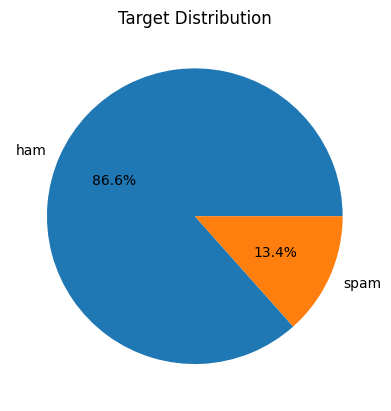

In [9]:
labels = df['target'].unique()
plt.pie(balance_counts, labels=labels, autopct='%1.1f%%')
plt.title('Target Distribution')
plt.show()

In [10]:
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,target_encoded,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,20
1,ham,Ok lar... Joking wif u oni...,0,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28
3,ham,U dun say so early hor... U c already then say...,0,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13


In [11]:
max(df['message_len'])

171

In [12]:
# checking duplicates...
df.duplicated().sum()

403

In [13]:
# ...and removing duplicates
df = df.drop_duplicates(keep="first")
df.duplicated().sum()

0

In [14]:
df['num_characters'] = df['message'].apply(len)
df["num_sentences"] = df["message"].apply(lambda x: len(nltk.sent_tokenize(x)))

df.head()

,target,message,target_encoded,message_len,num_characters,num_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,2
1,ham,Ok lar... Joking wif u oni...,0,6,29,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,2
3,ham,U dun say so early hor... U c already then say...,0,11,49,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,1


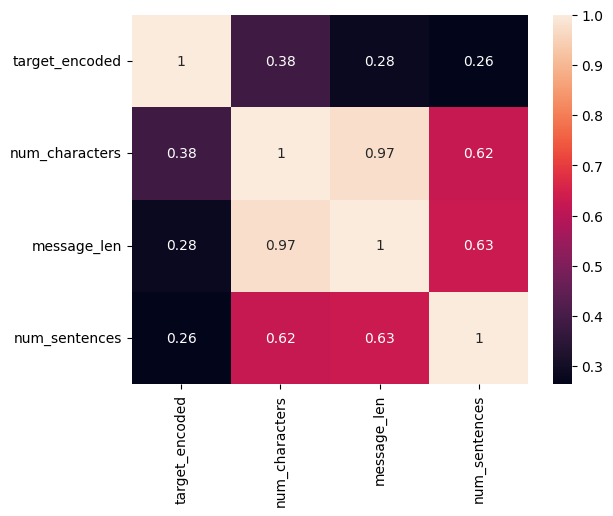

In [15]:
columns_to_include = ['target_encoded','num_characters', 'message_len', 'num_sentences']
subset_df = df[columns_to_include]

correlation_matrix = subset_df.corr()

sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [16]:
mean_length = df["num_characters"].mean()

spam_percentage = (df["target"].value_counts(normalize=True)[1]) * 100
ham_percentage = (df["target"].value_counts(normalize=True)[0]) * 100

spam_message = df[df["target"]== "spam"]
spam_mean_length = spam_message["message"].str.len().mean()
non_spam_message = df[df["target"]== "ham"]
non_spam_mean_length = non_spam_message["message"].str.len().mean()

# Identify not usable SMS messages (with less than 3 characters)
not_usable_count = (df["message_len"] <= 2).sum()

print("Mean Length of SMS Messages: {:.2f}".format(mean_length))
print("Percentage of Spam Messages: {:.2f}%".format(spam_percentage))
print("Percentage of Ham Messages: {:.2f}%".format(ham_percentage))
print("Mean Length of Spam Messages: {:.2f}".format(spam_mean_length))
print("Mean Length of Non-Spam Messages: {:.2f}".format(non_spam_mean_length))
print("Not Usable SMS Messages (less than 3 characters): {}".format(not_usable_count))

Mean Length of SMS Messages: 78.98
Percentage of Spam Messages: 12.63%
Percentage of Ham Messages: 87.37%
Mean Length of Spam Messages: 137.89
Mean Length of Non-Spam Messages: 70.46
Not Usable SMS Messages (less than 3 characters): 54


We can already see something quite interesting: the spam messages seems to be longer then non-spam messages. To have a better idea of this we decided to plot the two graphs of spam and non-spam messages.

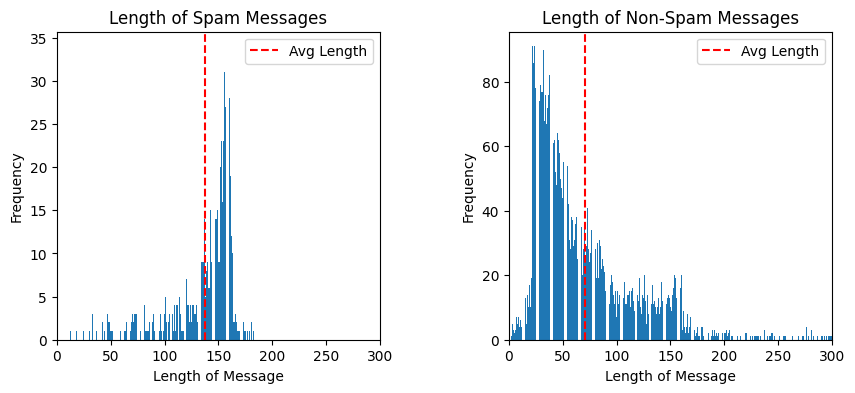

In [17]:
spam_messages = df[df["target"] == "spam"]
non_spam_messages = df[df["target"] == "ham"]

spam_message_lengths = spam_messages["message"].str.len()
non_spam_message_lengths = non_spam_messages["message"].str.len()

max_length = max(spam_message_lengths.max(), non_spam_message_lengths.max())

spam_length_counts = spam_message_lengths.value_counts().sort_index()
non_spam_length_counts = non_spam_message_lengths.value_counts().sort_index()

spam_avg_length = spam_message_lengths.mean()
non_spam_avg_length = non_spam_message_lengths.mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

ax1.bar(spam_length_counts.index, spam_length_counts.values)
ax1.axvline(x=spam_avg_length, color='red', linestyle='--', label='Avg Length')
ax1.set_xlabel("Length of Message")
ax1.set_ylabel("Frequency")
ax1.set_title("Length of Spam Messages")
ax1.legend()

ax2.bar(non_spam_length_counts.index, non_spam_length_counts.values)
ax2.axvline(x=non_spam_avg_length, color='red', linestyle='--', label='Avg Length')
ax2.set_xlabel("Length of Message")
ax2.set_ylabel("Frequency")
ax2.set_title("Length of Non-Spam Messages")
ax2.legend()

#plt.xlim(0, max_length)
plt.xlim(0, 300)
plt.subplots_adjust(wspace=0.4)
plt.show()

In [18]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\x00-\x7F]+', '', text) # remove non ascii chracter
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #text = re.sub('\[.*?\]', '', text)
    #text = re.sub('https?://\S+|www\.\S+', '', text)
    #text = re.sub('<.*?>+', '', text)
    #text = re.sub('\n', '', text)
    #text = re.sub('\w*\d\w*', '', text)

    return text

In [19]:
df.shape

(5169, 6)

In [20]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,target_encoded,message_len,num_characters,num_sentences,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,2,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,0,6,29,2,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,2,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,0,11,49,1,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,1,nah i dont think he goes to usf he lives aroun...


In [21]:
def remove_short_messages(df):
    df = df[df["message_clean"].apply(lambda x: len(x) > 2)]
    return df

df = remove_short_messages(df)
df.shape

(5162, 7)

In [22]:
def count_short_messages(df):
    count = 0
    for message in df["message_clean"]:
        if len(message) < 5:
            count += 1
    return count
short_message_count = count_short_messages(df)
print("Number of messages with less than 2 characters:", short_message_count)

Number of messages with less than 2 characters: 8


In [23]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
additional_stopwords = ["u", "im", "c", "k", "n"]
stop_words = stop_words + additional_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

,target,message,target_encoded,message_len,num_characters,num_sentences,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,2,go jurong point crazy available bugis great wo...
1,ham,Ok lar... Joking wif u oni...,0,6,29,2,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,2,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,11,49,1,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,1,nah dont think goes usf lives around though


In [25]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [26]:
df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,target_encoded,message_len,num_characters,num_sentences,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111,2,go jurong point crazi avail bugi great world l...
1,ham,Ok lar... Joking wif u oni...,0,6,29,2,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155,2,free entri 2 wkli comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,11,49,1,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61,1,nah dont think goe usf live around though


<ipython-input-27-9ef29b7c0191>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(word_freq_df['Word'], rotation=90)
<ipython-input-27-9ef29b7c0191>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(word_freq_df['Word'], rotation=90)


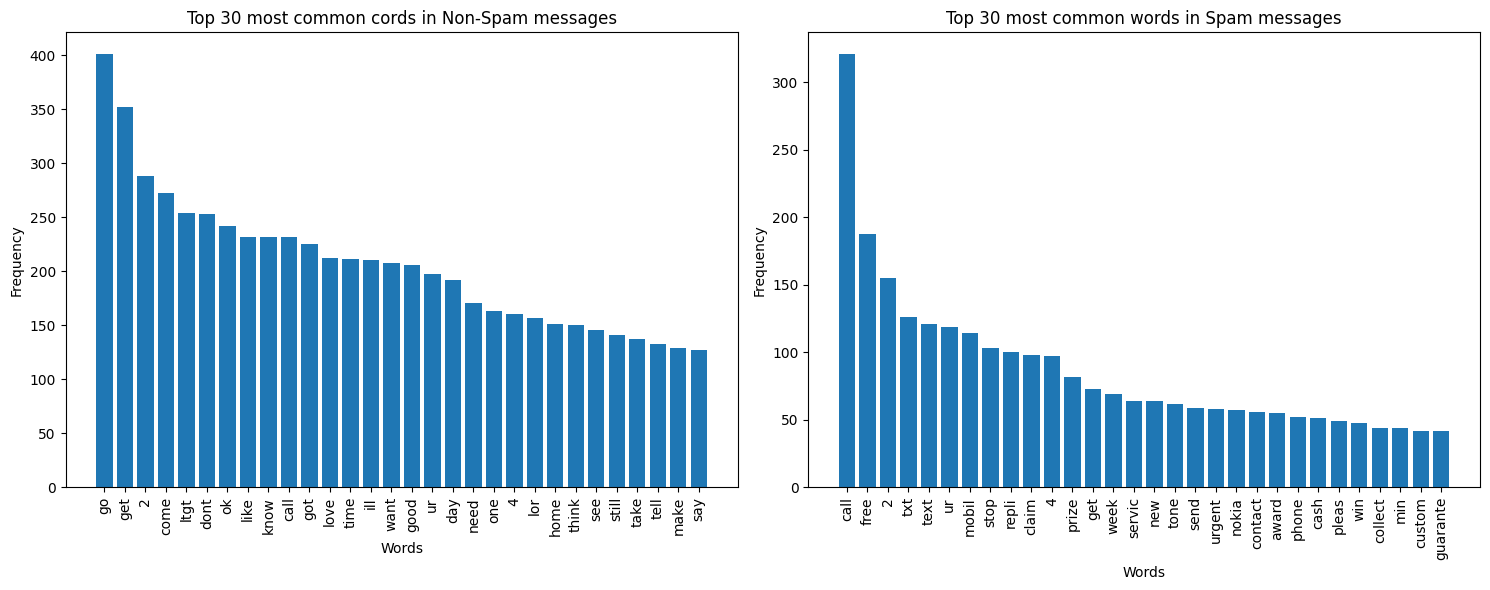

In [27]:
num_words = 30

non_spam_df = df[df['target_encoded'] == 0]

all_messages = ' '.join(non_spam_df['message_clean'].tolist())
words = all_messages.split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(num_words)
word_list, frequency_list = zip(*most_common_words)
word_freq_df = pd.DataFrame({'Word': word_list, 'Frequency': frequency_list})
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].bar(word_freq_df['Word'], word_freq_df['Frequency'])
axes[0].set_xticklabels(word_freq_df['Word'], rotation=90)
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Top ' + str(num_words) + ' most common cords in Non-Spam messages')

spam_df = df[df['target_encoded'] == 1]
all_messages = ' '.join(spam_df['message_clean'].tolist())
words = all_messages.split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(num_words)
word_list, frequency_list = zip(*most_common_words)
word_freq_df = pd.DataFrame({'Word': word_list, 'Frequency': frequency_list})
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)
axes[1].bar(word_freq_df['Word'], word_freq_df['Frequency'])
axes[1].set_xticklabels(word_freq_df['Word'], rotation=90)
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Top ' + str(num_words) + ' most common words in Spam messages')
plt.tight_layout()
plt.show()

# 03 - Vectorization

In [28]:
x = df['message_clean']
y = df['target_encoded']

print(len(x)==len(y))
print(len(x), len(y))

True
5162 5162


In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state=42)
print("Length x_train: {:d},    Length y_train: {:d}".format(int(len(x_train)), int(len(y_train))))
print("Length x_test: {:d},     Length y_test: {:d}".format(int(len(x_test)), int(len(y_test))))

Length x_train: 4129,    Length y_train: 4129
Length x_test: 1033,     Length y_test: 1033


In [30]:
print(x_train[:5])

2899                    come aftr  ltdecimalgt clean hous
437                                long applebe fuck take
590     ur chanc win 250 wkli shop spree txt shop 8087...
3771                             uncl timi help clear car
2420                       oic better quick go bath settl
Name: message_clean, dtype: object


In [31]:
ros = RandomOverSampler(sampling_strategy=0.8, random_state=42)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train.to_frame(), y_train)

In [32]:
count_train = pd.Series(y_train).value_counts()
print("Number of 1s in y_train:", count_train[1])
print("Number of 0s in y_train:", count_train[0])

count_train_resampled = y_train_resampled.value_counts()
print("Number of 1s (spam) in y_train_resampled:", count_train_resampled[1])
print("Number of 0s (ham) in y_train_resampled:", count_train_resampled[0])

Number of 1s in y_train: 522
Number of 0s in y_train: 3607
Number of 1s (spam) in y_train_resampled: 2885
Number of 0s (ham) in y_train_resampled: 3607


In [33]:
print(type(x_train_resampled))

<class 'pandas.core.frame.DataFrame'>


In [34]:
x_train_resampled = x_train_resampled['message_clean'].squeeze()

In [35]:
print(type(x_train_resampled))

<class 'pandas.core.series.Series'>


In [36]:
### replaced x_train with x_train_resampled, y_train with y_train_resampled
x_train = x_train_resampled
y_train = y_train_resampled

# 04 - Embedding

## 04.01 CountVectorizer

In [37]:
#vect = CountVectorizer()
vect = CountVectorizer(lowercase=True, stop_words= stop_words, ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)
vect.fit(x_train)

CountVectorizer(max_df=0.7, max_features=100, min_df=0.1, ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [38]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [39]:
print(x_train_dtm.shape)

(6492, 2)


In [40]:
print(type(x_train_dtm))

<class 'scipy.sparse._csr.csr_matrix'>


In [41]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

## 04.02 - TF-IDF

In [42]:
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<6492x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2064 stored elements in Compressed Sparse Row format>

## 04.03 - Word Embedding: BPE

In [43]:
texts = df['message_clean']
target = df['target_encoded']

In [44]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

8009

In [45]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[   3, 3269,  271, ...,    0,    0,    0],
       [  11,  221,  575, ...,    0,    0,    0],
       [  13,  413,    2, ...,    0,    0,    0],
       ...,
       [8007, 1437, 8008, ...,    0,    0,    0],
       [ 135, 1231, 1584, ...,    0,    0,    0],
       [1979,  436,  182, ...,    0,    0,    0]], dtype=int32)

In [46]:
embeddings_dictionary = dict()


# BPE TRAINED BY US
with open('dict_spam_embedding.txt') as fp:
  for line in fp.readlines():
      records = line.split()
      word = records[0]
      vector_dimensions = np.asarray(records[1:], dtype='float32')
      embeddings_dictionary [word] = vector_dimensions

"""
# GLOVE
embeddings_dictionary = {}
with open('glove.6B.100d.txt', encoding='utf-8') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
"""

"\n# GLOVE\nembeddings_dictionary = {}\nwith open('glove.6B.100d.txt', encoding='utf-8') as fp:\n    for line in fp.readlines():\n        records = line.split()\n        word = records[0]\n        vector_dimensions = np.asarray(records[1:], dtype='float32')\n        embeddings_dictionary[word] = vector_dimensions\n"

In [47]:
embedding_dim = 5   # cambiare a seconda del nostro BPE (mettere 5) o glove (mettere 100)

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# 05 - Modeling

In [48]:
print(x_train_dtm.shape)
print(y_train.shape)

(6492, 2)
(6492,)


## 05.01 - XGBoost

In [49]:
pipe = Pipeline([
    ('bow', CountVectorizer()),
    #('bow', CountVectorizer(lowercase=True, stop_words=stop_words, ngram_range=(1,9), min_df=0.05, max_df=0.95, max_features=750)),
    ('tfid', TfidfTransformer()),
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=11,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [50]:
pipe.fit(x_train, y_train)

y_pred_class_xgb = pipe.predict(x_test)
y_pred_train_xgb = pipe.predict(x_train)

print('Train: {}'.format(accuracy_score(y_train, y_pred_train_xgb)))
print('Test: {}'.format(accuracy_score(y_test, y_pred_class_xgb)))

acc_train_xgb = accuracy_score(y_train, y_pred_train_xgb)
acc_test_xgb = accuracy_score(y_test, y_pred_class_xgb)

conf_xgb = confusion_matrix(y_test, y_pred_class_xgb)
print(conf_xgb)

Train: 0.9887553912507702
Test: 0.9690222652468539
[[891  11]
 [ 21 110]]


## 05.02 - LSTM

In [51]:
print(train_padded_sentences)

[[   3 3269  271 ...    0    0    0]
 [  11  221  575 ...    0    0    0]
 [  13  413    2 ...    0    0    0]
 ...
 [8007 1437 8008 ...    0    0    0]
 [ 135 1231 1584 ...    0    0    0]
 [1979  436  182 ...    0    0    0]]


In [52]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.20  # try 0.25
)

In [53]:
frequencies = y_train_lstm.value_counts()

print("Frequency of 0:", frequencies.get(0, 0))
print("Frequency of 1:", frequencies.get(1, 0))

Frequency of 0: 3599
Frequency of 1: 530


In [54]:
ros_lstm = RandomOverSampler(sampling_strategy=0.8, random_state=42)
X_train_lstm_resampled, y_train_lstm_resampled = ros_lstm.fit_resample(X_train_lstm, y_train_lstm)

In [55]:
frequencies = y_train_lstm_resampled.value_counts()

print("Frequency of 0:", frequencies.get(0, 0))
print("Frequency of 1:", frequencies.get(1, 0))

Frequency of 0: 3599
Frequency of 1: 2879


In [56]:
print(type(X_train_lstm))
print(type(X_train_lstm_resampled))
print(type(y_train_lstm))
print(type(y_train_lstm_resampled))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [57]:
### APPLY RandomOverSampler
X_train_lstm = X_train_lstm_resampled
y_train_lstm = y_train_lstm_resampled

In [58]:
def glove_lstm():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence
    ))

    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 5)             40045     
                                                                 
 bidirectional (Bidirectiona  (None, 80, 160)          55040     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 160)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                        

In [59]:
model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs = 7,  # try with 7
    batch_size = 32,
    validation_data = (X_test_lstm, y_test_lstm),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
203/203 [==============================] - ETA: 0s - loss: 0.5339 - accuracy: 0.7299
Epoch 1: val_loss improved from inf to 0.64811, saving model to model.h5
203/203 [==============================] - 178s 769ms/step - loss: 0.5339 - accuracy: 0.7299 - val_loss: 0.6481 - val_accuracy: 0.7144 - lr: 0.0010
Epoch 2/7
203/203 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9293
Epoch 2: val_loss improved from 0.64811 to 0.24710, saving model to model.h5
203/203 [==============================] - 138s 679ms/step - loss: 0.2231 - accuracy: 0.9293 - val_loss: 0.2471 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 3/7
203/203 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9589
Epoch 3: val_loss improved from 0.24710 to 0.06696, saving model to model.h5
203/203 [==============================] - 135s 667ms/step - loss: 0.1355 - accuracy: 0.9589 - val_loss: 0.0670 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 4/7
203/203 [=========================

In [60]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

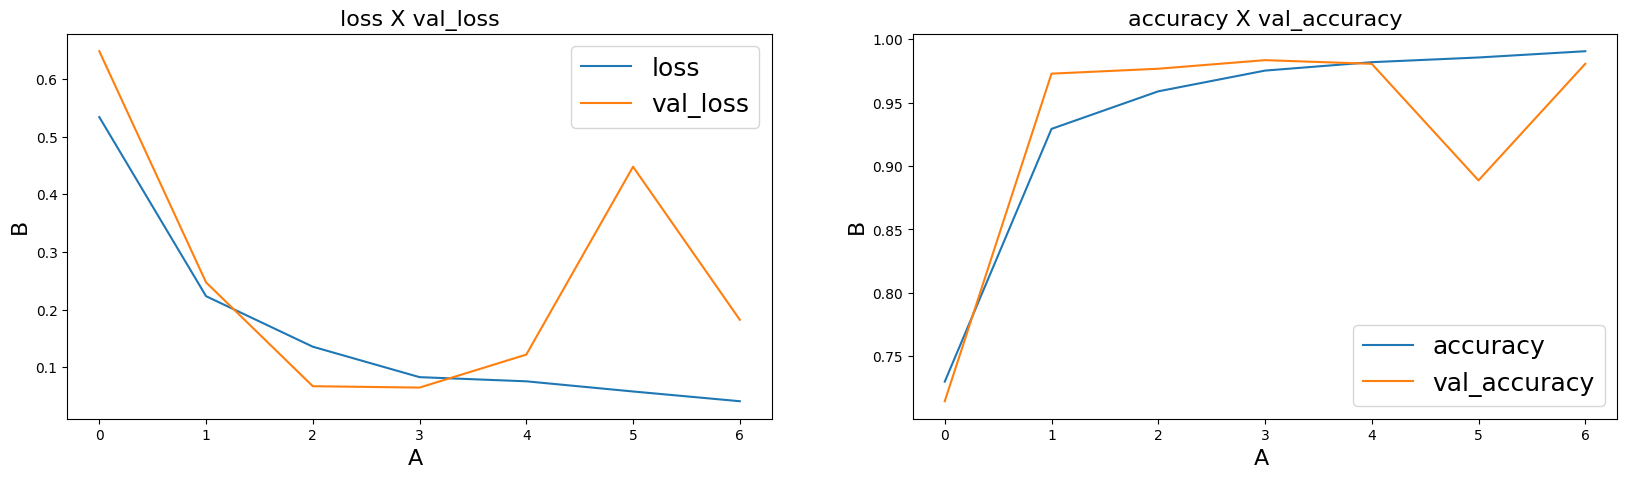

In [61]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [62]:
# LSTM
y_pred_train_lstm = (model.predict(X_train_lstm) > 0.5).astype("int32")
y_pred_test_lstm = (model.predict(X_test_lstm) > 0.5).astype("int32")

print('Train: {}'.format(accuracy_score(y_train_lstm, y_pred_train_lstm)))
print('Test: {}'.format(accuracy_score(y_test_lstm, y_pred_test_lstm)))

acc_train_lstm = accuracy_score(y_train_lstm, y_pred_train_lstm)
acc_test_lstm = accuracy_score(y_test_lstm, y_pred_test_lstm)

conf_lstm = confusion_matrix(y_test, y_pred_test_lstm)
print(conf_lstm)

33/33 [==============================] - 1s 45ms/step
Train: 0.9953689410311825
Test: 0.9806389157792836
[[803  99]
 [121  10]]



## 05.03 - BERT

In [63]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [64]:
texts_train_bert, texts_test_bert, target_train_bert, target_test_bert = train_test_split(df['message_clean'], df['target_encoded'], test_size=0.2, stratify = y, random_state=42)

In [65]:
frequencies = target_train_bert.value_counts()

print("Frequency of 0:", frequencies.get(0, 0))
print("Frequency of 1:", frequencies.get(1, 0))

Frequency of 0: 3607
Frequency of 1: 522


In [66]:
#texts_train = df['message_clean']
#target_train = df['target_encoded']

train_input_ids_bert, train_attention_masks_bert = bert_encode(texts_train_bert,60)
test_input_ids_bert, test_attention_masks_bert = bert_encode(texts_test_bert,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [67]:
def create_model(bert_model):

    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [68]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [69]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

In [70]:
history = model.fit(
    [train_input_ids_bert, train_attention_masks_bert],
    target_train_bert,
    validation_split=0.2,
    epochs=7,
    batch_size=10
)

Epoch 1/7
331/331 [==============================] - 127s 233ms/step - loss: 0.4158 - accuracy: 0.8689 - val_loss: 0.3807 - val_accuracy: 0.8765
Epoch 2/7
331/331 [==============================] - 55s 166ms/step - loss: 0.4045 - accuracy: 0.8728 - val_loss: 0.3899 - val_accuracy: 0.8765
Epoch 3/7
331/331 [==============================] - 56s 168ms/step - loss: 0.4049 - accuracy: 0.8728 - val_loss: 0.3765 - val_accuracy: 0.8765
Epoch 4/7
331/331 [==============================] - 53s 162ms/step - loss: 0.3985 - accuracy: 0.8728 - val_loss: 0.3749 - val_accuracy: 0.8765
Epoch 5/7
331/331 [==============================] - 54s 163ms/step - loss: 0.4016 - accuracy: 0.8728 - val_loss: 0.3738 - val_accuracy: 0.8765
Epoch 6/7
331/331 [==============================] - 54s 162ms/step - loss: 0.3992 - accuracy: 0.8728 - val_loss: 0.3827 - val_accuracy: 0.8765
Epoch 7/7
331/331 [==============================] - 55s 165ms/step - loss: 0.3965 - accuracy: 0.8728 - val_loss: 0.4010 - val_accuracy

In [71]:
print(train_input_ids_bert)

[[  101  2272 16638 ...     0     0     0]
 [  101  2146  6207 ...     0     0     0]
 [  101 24471  9212 ...     0     0     0]
 ...
 [  101 25353 27718 ...     0     0     0]
 [  101  2272  2157 ...     0     0     0]
 [  101 16215  2243 ...     0     0     0]]


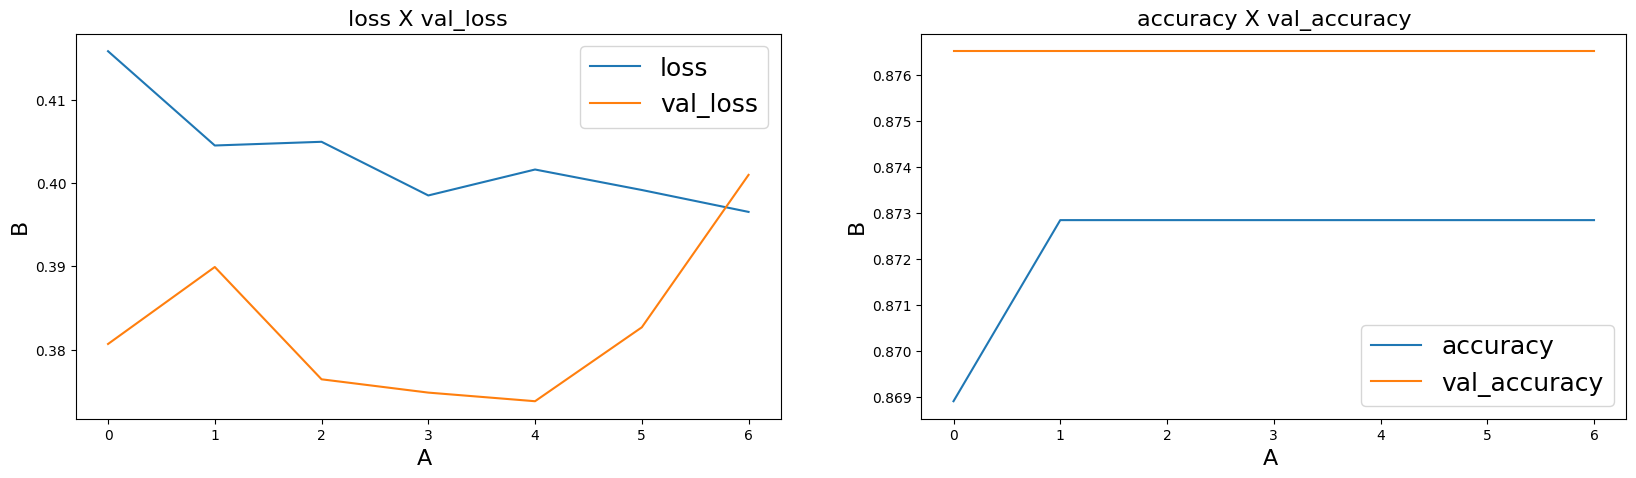

In [72]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [73]:
pred_y_test_bert = model.predict([test_input_ids_bert, test_attention_masks_bert])
pred_y_train_bert = model.predict([train_input_ids_bert, train_attention_masks_bert])

130/130 [==============================] - 17s 132ms/step


In [74]:
predicted_y_test_bert_flatten = np.round(pred_y_test_bert).flatten()
predicted_y_train_bert_flatten = np.round(pred_y_train_bert).flatten()

In [75]:
# BERT
print('Train: {}'.format(accuracy_score(target_train_bert, predicted_y_train_bert_flatten)))
print('Test: {}'.format(accuracy_score(target_test_bert, predicted_y_test_bert_flatten)))

acc_train_bert = accuracy_score(target_train_bert, predicted_y_train_bert_flatten)
acc_test_bert = accuracy_score(target_test_bert, predicted_y_test_bert_flatten)

conf_bert = confusion_matrix(target_test_bert, predicted_y_test_bert_flatten)
print(conf_bert)

Train: 0.8735771373213853
Test: 0.8731848983543078
[[902   0]
 [131   0]]


# 05 - Comparing models

## 05.01 - Confusion Matrix

In [76]:
# XGBoost
print('Accuracy score on train: {}'.format(accuracy_score(y_train, y_pred_train_xgb)))
print('Accuract score on test: {}'.format(accuracy_score(y_test, y_pred_class_xgb)))
print('F1_score on train: {}'.format(f1_score(y_train, y_pred_train_xgb)))
print('F1_score on test: {}'.format(f1_score(y_test, y_pred_class_xgb)))

acc_train_xgb = accuracy_score(y_train, y_pred_train_xgb)
acc_test_xgb = accuracy_score(y_test, y_pred_class_xgb)

conf_xgb = confusion_matrix(y_test, y_pred_class_xgb)
print(conf_xgb)

Accuracy score on train: 0.9887553912507702
Accuract score on test: 0.9690222652468539
F1_score on train: 0.987244452210379
F1_score on test: 0.873015873015873
[[891  11]
 [ 21 110]]


In [77]:
# LSTM
print('Accuracy score on train: {}'.format(accuracy_score(y_train_lstm, y_pred_train_lstm)))
print('Accuract score on test: {}'.format(accuracy_score(y_test_lstm, y_pred_test_lstm)))
print('F1_score on train: {}'.format(f1_score(y_train_lstm, y_pred_train_lstm)))
print('F1_score on test: {}'.format(f1_score(y_test_lstm, y_pred_test_lstm)))

acc_train_lstm = accuracy_score(y_train_lstm, y_pred_train_lstm)
acc_test_lstm = accuracy_score(y_test_lstm, y_pred_test_lstm)

conf_lstm = confusion_matrix(y_test, y_pred_test_lstm)
print(conf_lstm)

Accuracy score on train: 0.9953689410311825
Accuract score on test: 0.9806389157792836
F1_score on train: 0.9947680502267179
F1_score on test: 0.9137931034482759
[[803  99]
 [121  10]]


In [78]:
# BERT
print('Accuracy score on train: {}'.format(accuracy_score(target_train_bert, predicted_y_train_bert_flatten)))
print('Accuract score on test: {}'.format(accuracy_score(target_test_bert, predicted_y_test_bert_flatten)))
print('F1_score on train: {}'.format(f1_score(target_train_bert, predicted_y_train_bert_flatten)))
print('F1_score on test: {}'.format(f1_score(target_test_bert, predicted_y_test_bert_flatten)))

acc_train_bert = accuracy_score(target_train_bert, predicted_y_train_bert_flatten)
acc_test_bert = accuracy_score(target_test_bert, predicted_y_test_bert_flatten)

conf_bert = confusion_matrix(target_test_bert, predicted_y_test_bert_flatten)
print(conf_bert)

Accuracy score on train: 0.8735771373213853
Accuract score on test: 0.8731848983543078
F1_score on train: 0.0
F1_score on test: 0.0
[[902   0]
 [131   0]]


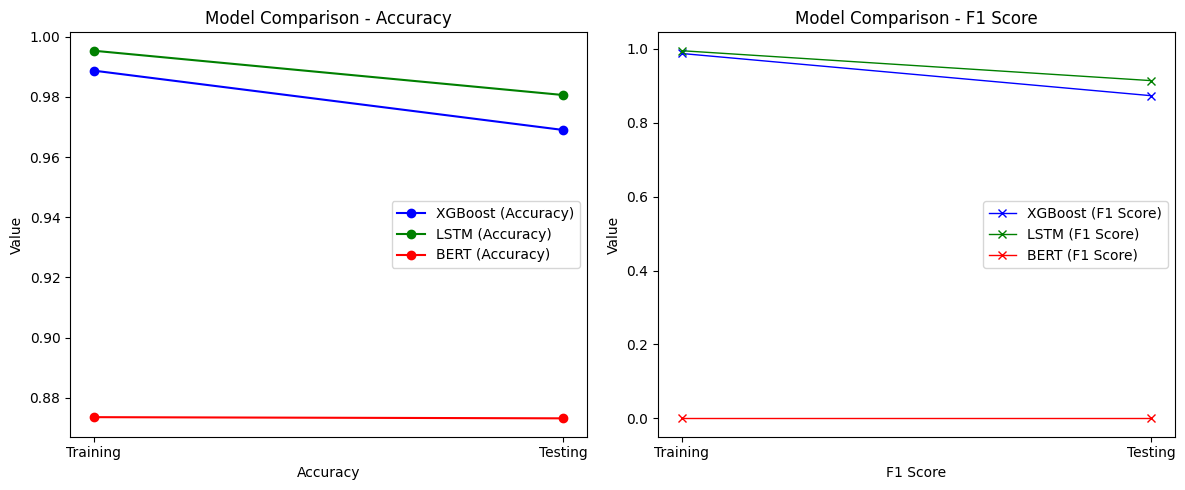

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot([0, 1], [acc_train_xgb, acc_test_xgb], marker='o', color='blue', label='XGBoost (Accuracy)')
ax1.plot([0, 1], [acc_train_lstm, acc_test_lstm], marker='o', color='green', label='LSTM (Accuracy)')
ax1.plot([0, 1], [acc_train_bert, acc_test_bert], marker='o', color='red', label='BERT (Accuracy)')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Training', 'Testing'])
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('Value')
ax1.set_title('Model Comparison - Accuracy')
ax1.legend()

ax2.plot([0, 1], [f1_score_xgb_train, f1_score_xgb_test], marker='x', color='blue', linewidth=1, label='XGBoost (F1 Score)')
ax2.plot([0, 1], [f1_score_lstm_train, f1_score_lstm_test], marker='x', color='green', linewidth=1, label='LSTM (F1 Score)')
ax2.plot([0, 1], [f1_score_bert_train, f1_score_bert_test], marker='x', color='red', linewidth=1, label='BERT (F1 Score)')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Training', 'Testing'])
ax2.set_xlabel('F1 Score')
ax2.set_ylabel('Value')
ax2.set_title('Model Comparison - F1 Score')
ax2.legend()

plt.tight_layout()
plt.show()

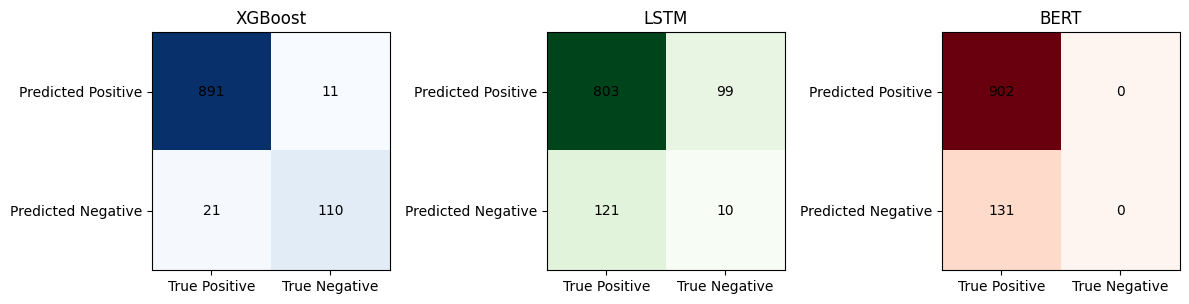

In [81]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# XGBoost
axs[0].imshow(conf_xgb, cmap='Blues')
axs[0].set_title('XGBoost')
axs[0].set_xticks([0, 1])
axs[0].set_yticks([0, 1])
axs[0].set_xticklabels(['True Positive','True Negative'])
axs[0].set_yticklabels(['Predicted Positive','Predicted Negative',])
for i in range(2):
    for j in range(2):
        axs[0].text(j, i, str(conf_xgb[i, j]), ha='center', va='center', color='black')


# LSTM
axs[1].imshow(conf_lstm, cmap='Greens')
axs[1].set_title('LSTM')
axs[1].set_xticks([0, 1])
axs[1].set_yticks([0, 1])
axs[1].set_xticklabels(['True Positive','True Negative'])
axs[1].set_yticklabels(['Predicted Positive', 'Predicted Negative'])
for i in range(2):
    for j in range(2):
        axs[1].text(j, i, str(conf_lstm[i, j]), ha='center', va='center', color='black')


# BERT
axs[2].imshow(conf_bert, cmap='Reds')
axs[2].set_title('BERT')
axs[2].set_xticks([0, 1])
axs[2].set_yticks([0, 1])
axs[2].set_xticklabels(['True Positive','True Negative'])
axs[2].set_yticklabels(['Predicted Positive','Predicted Negative',])
for i in range(2):
    for j in range(2):
        axs[2].text(j, i, str(conf_bert[i, j]), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

## 05.02 - Testing with new sentences

In [82]:
# XGBOOST
def classify_string_xgb(text):
  predicted_class_xgb = pipe.predict([text])
  classification_xgb = 'ham' if predicted_class_xgb == 0 else 'spam'
  return(classification_xgb)

In [83]:
# LSTM

def preprocess_input(text):
    cleaned_text = clean_text(text)
    stopwords_removed = remove_stopwords(cleaned_text)
    stemmed_text = stemm_text(stopwords_removed)
    #print(stemmed_text)
    return stemmed_text

def classify_string_lstm(text):
    preprocessed_input = preprocess_input(text)
    input_sequence = pad_sequences(embed([preprocessed_input]), length_long_sentence)
    loaded_model = load_model('model.h5')
    pred = loaded_model.predict(input_sequence)
    labels_lstm = ['ham' if p < 0.5 else 'spam' for p in pred.flatten()]

    return labels_lstm[0]

In [84]:
# BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

def classify_string_bert(string):
    inputs = tokenizer(string, padding=True, truncation=True, max_length=60, return_tensors='tf')
    outputs = model(inputs)
    logits = outputs.logits
    predictions = tf.nn.sigmoid(logits)
    labels = ['ham' if pred < 0.5 else 'spam' for pred in predictions.numpy().flatten()]

    return labels[0]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
new_string_test = "buy a new toy and get one for free, only today"

print("------")
print("XGBoost")
classification_xgb = classify_string_xgb(new_string_test)
print("------")
print("LSTM")
classification_lstm = classify_string_lstm(new_string_test)
print("------")
print("BERT")
classification_bert = classify_string_bert(new_string_test)

------
XGBoost
------
LSTM


1/1 [==============================] - 0s 497ms/step
------
BERT


In [86]:
print("Predicted label with XGBoost: {}".format(classification_xgb))
print("Predicted label with LSTM: {}".format(classification_lstm))
print("Predicted label with BERT: {}".format(classification_bert))

Predicted label with XGBoost: ham
Predicted label with LSTM: ham
Predicted label with BERT: spam


In [87]:
def classify_multiple_sentences(sentences):
    sentence_list = [sentence.strip() for sentence in sentences.split(',')]

    table_data = [['Model'] + sentence_list]

    for model_name in ['XGBoost', 'LSTM', 'BERT']:
        row_data = [model_name]
        for sentence in sentence_list:
            if model_name == 'XGBoost':
                classification = classify_string_xgb(sentence)
            elif model_name == 'LSTM':
                classification = classify_string_lstm(sentence)
            else:
                classification = classify_string_bert(sentence)
            row_data.append(classification)
        table_data.append(row_data)

    return table_data

# Insert here all the sentences, separated by a comma
sentences = "buy a new toy and get one for free, only today, win a free vacation, limited time offer, free free free get free, my best friend is marco, should I visit venice?"
results = classify_multiple_sentences(sentences)

table = tabulate(results, headers='firstrow', tablefmt='fancy_grid')
print(table)

1/1 [==============================] - 0s 494ms/step


1/1 [==============================] - 0s 474ms/step


1/1 [==============================] - 0s 456ms/step


1/1 [==============================] - 0s 476ms/step


1/1 [==============================] - 1s 667ms/step


1/1 [==============================] - 1s 678ms/step


1/1 [==============================] - 1s 676ms/step
╒═════════╤══════════════════════════════════════╤══════════════╤═══════════════════════╤══════════════════════╤═══════════════════════════╤═══════════════════════════╤══════════════════════════╕
│ Model   │ buy a new toy and get one for free   │ only today   │ win a free vacation   │ limited time offer   │ free free free get free   │ my best friend is marco   │ should I visit venice?   │
╞═════════╪══════════════════════════════════════╪══════════════╪═══════════════════════╪══════════════════════╪═══════════════════════════╪═══════════════════════════╪══════════════════════════╡
│ XGBoost │ ham                                  │ ham          │ ham                   │ ham                  │ ham                       │ ham                       │ ham                      │
├─────────┼──────────────────────────────────────┼──────────────┼───────────────────────┼──────────────────────┼───────────────────────────┼───────────────────────